In [6]:
!unzip "/content/drive/MyDrive/fer2013.tar"

Archive:  /content/drive/MyDrive/fer2013.tar
   creating: fer2013/
  inflating: fer2013/README          
  inflating: fer2013/fer2013.bib     
  inflating: fer2013/fer2013.csv     


In [7]:
#dependencies
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv2D, Activation, MaxPool2D, Dropout, Dense, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint
import tarfile

In [10]:
!unzip "fer2013/fer2013.csv"

Archive:  fer2013/fer2013.csv
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of fer2013/fer2013.csv or
        fer2013/fer2013.csv.zip, and cannot find fer2013/fer2013.csv.ZIP, period.


In [11]:
#dataset
ds = pd.read_csv("/content/fer2013/fer2013.csv")
ds.head()
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
ds["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [13]:
train = ds[["emotion", "pixels"]][ds["Usage"] == "Training"]
train['pixels'] = train['pixels'].apply(lambda x: np.fromstring(x, sep=' '))
train_pix = np.vstack(train['pixels'].values)
test = ds[["emotion", "pixels"]][ds["Usage"] == "PublicTest"]
test['pixels'] = test['pixels'].apply(lambda x: np.fromstring(x, sep=' '))
test_pix = np.vstack(test['pixels'].values)
train_pix.shape, test_pix.shape

((28709, 2304), (3589, 2304))

In [14]:
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
#0=angry, 1=disgust+fear+surprise, 3=Happy, 4=sad, 6= neutral
#apending 2 and 5 to 1; 5 to 2; 6 to 4
#:::: set append = false to avoid changes
def e_ind(x):
    if(x==2 or x==5):
        return 1
    elif(x==5):
        return 2
    elif(x==6):
        return 4
    else:
        return x
F_S_D = True
if(F_S_D):
    train['emotion'] = train['emotion'].apply(lambda x: e_ind(x))
    test['emotion'] = test['emotion'].apply(lambda x: e_ind(x))
train_ind = np.array(train["emotion"])
test_ind = np.array(test["emotion"])
train_ind.shape, test_ind.shape

((28709,), (3589,))

In [15]:
train_pix = train_pix.reshape(-1,48,48,1)
train_ind = np_utils.to_categorical(train_ind)
test_pix = test_pix.reshape(-1,48,48,1)
test_ind = np_utils.to_categorical(test_ind)
train_ind.shape, test_ind.shape
#train_pix.shape, test_pix.shape

((28709, 5), (3589, 5))

In [16]:
model = Sequential()
model.add(Conv2D(64, 5, data_format="channels_last", kernel_initializer="he_normal", 
                 input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, 4))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.5))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))

if(F_S_D):
    model.add(Dense(5))
else:
    model.add(Dense(7))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 44, 44, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 44, 44, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 41, 41, 64)        65600     
                                                                 
 batch_normalization_1 (Batc  (None, 41, 41, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 41, 41, 64)        0

In [17]:
# checkpoint
checkPoint = ModelCheckpoint(filepath='chkPt1.h5', verbose=1, save_best_only=True)

res = model.fit(train_pix, train_ind, epochs=16,
                 shuffle=True,
                 batch_size=100, 
                 validation_data=(test_pix, test_ind),
                 callbacks=[checkPoint], 
                 verbose=2)

# save model to json
model_json = model.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)

Epoch 1/16

Epoch 1: val_loss improved from inf to 1.09563, saving model to chkPt1.h5
288/288 - 21s - loss: 1.2938 - accuracy: 0.4518 - val_loss: 1.0956 - val_accuracy: 0.5481 - 21s/epoch - 71ms/step
Epoch 2/16

Epoch 2: val_loss improved from 1.09563 to 0.99424, saving model to chkPt1.h5
288/288 - 9s - loss: 1.0755 - accuracy: 0.5458 - val_loss: 0.9942 - val_accuracy: 0.5846 - 9s/epoch - 32ms/step
Epoch 3/16

Epoch 3: val_loss improved from 0.99424 to 0.96950, saving model to chkPt1.h5
288/288 - 9s - loss: 0.9990 - accuracy: 0.5853 - val_loss: 0.9695 - val_accuracy: 0.5993 - 9s/epoch - 31ms/step
Epoch 4/16

Epoch 4: val_loss improved from 0.96950 to 0.93892, saving model to chkPt1.h5
288/288 - 9s - loss: 0.9529 - accuracy: 0.6094 - val_loss: 0.9389 - val_accuracy: 0.6225 - 9s/epoch - 32ms/step
Epoch 5/16

Epoch 5: val_loss improved from 0.93892 to 0.87556, saving model to chkPt1.h5
288/288 - 9s - loss: 0.9188 - accuracy: 0.6235 - val_loss: 0.8756 - val_accuracy: 0.6467 - 9s/epoch - 31

No handles with labels found to put in legend.


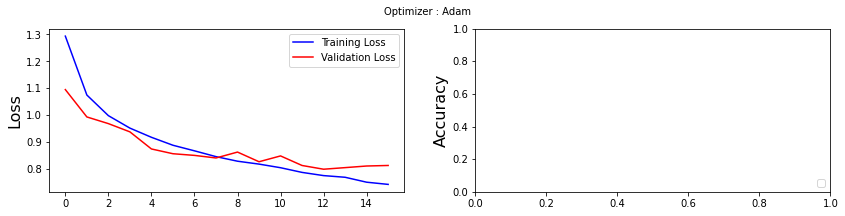

In [25]:
import seaborn as sns
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(res.history['loss'], color='b', label='Training Loss')
plt.plot(res.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
#plt.plot(res.history['acc'], color='b', label='Training Accuracy')
#plt.plot(res.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [20]:
score = model.evaluate(test_pix, test_ind, verbose=0)
score

[0.8143378496170044, 0.6776260733604431]

In [21]:
from keras.models import model_from_json
import numpy as np

class FacialExpressionModel(object):
    EMOTIONS_LIST = ["Angry", "Disgust/fear/surprise","Sad","Happy", "Neutral"]

    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        print("Model loaded from disk")
        self.loaded_model.summary()

    def predict_emotion(self, img):
        self.preds = self.loaded_model.predict(img)

        return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]


if __name__ == '__main__':
    pass